# Translation with a Sequence to Sequence Network and Attention

In this project we will be teaching a neural network to translate from
French to English.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215>), in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

![](imgs/seq2seq.png)

To improve upon this model we'll use an [attention
mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder
learn to focus over a specific range of the input sequence.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading data files
The data for this project is a set of many thousands of English to
French translation pairs.

In [2]:
def download_dataset():
    ! wget https://download.pytorch.org/tutorial/data.zip
    ! unzip data.zip

In [3]:
# to download the dataset
download_dataset()

--2019-03-10 15:42:37--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.239.132.161, 54.239.132.154, 54.239.132.46, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.239.132.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  18.2MB/s    in 0.2s    

2019-03-10 15:42:40 (18.2 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names

We will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). 
![](imgs/word-encoding.png) 

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.

In [4]:
SOS_token = 0
EOS_token = 1
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [5]:
def unicodeToAscii(s):
    """Turn a Unicode string to plain ASCII
    
    https://stackoverflow.com/a/518232/2809427
    """
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    """Lowercase, trim, and remove non-letter characters"""
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "We are" and "They are". (accounting for apostrophes replaced
earlier).




In [7]:
MAX_LENGTH = 10

eng_prefixes = (
    #"i am ", "i m ",
    #"he is", "he s ",
    #"she is", "she s ",
    #"you are", "you re ",
    # I was experimenting using just "we are sentences"
    "we are", "we re ",
    #"they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [8]:
NUM_TRAIN = 2000
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    #randomize the data with a fixed seed for repeatability
    random.seed(4)
    random.shuffle(pairs)
    pairs = pairs[0:NUM_TRAIN+10]
    #choose the first 10 pairs for testing and the rest for training
    testPairs = pairs[0:10]
    trainPairs = pairs[10:len(pairs)]

    
    print("number of test pairs: %s" % len(testPairs))
    print("number of train pairs: %s" % len(trainPairs))
    
    print("Counting words...")
    cnt = 0
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs, trainPairs, testPairs

input_lang, output_lang, pairs, trainPairs, testPairs = prepareData('eng', 'fra', True)
random.seed(4)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 1113 sentence pairs
number of test pairs: 10
number of train pairs: 1103
Counting words...
Counted words:
fra 906
eng 695
['nous avons presque acheve ce travail .', 'we re just about finished with this job .']


The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

![](imgs/seq2seq.png)

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

![](imgs/encoder-network.png)

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

![](imgs/decoder-network.png)

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder


If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

![](https://i.imgur.com/1152PYf.png)

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

![](imgs/attention-decoder-network.png)




In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        #print('debug: in AttnDecoderRNN')
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        #print('debug')
        #print(embedded[0].size(), hidden[0].size())

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)

        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
class AttnDotDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDotDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, 1)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        scorefunc = torch.zeros(1, encoder_outputs.size(0), device=device)
        for ei in range(encoder_outputs.size(0)):
            scorefunc[0, ei] = torch.dot(encoder_outputs[ei], hidden[0,0])
         
        attn_weights = F.softmax(scorefunc, dim=1)
            
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [13]:
class AttnMultiplicativeDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnMultiplicativeDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        scorefunc = torch.zeros(1, encoder_outputs.size(0), device=device)
        for ei in range(encoder_outputs.size(0)):
            scorefunc[0, ei] = torch.dot(encoder_outputs[ei], self.attn(hidden[0,0]))
         
        attn_weights = F.softmax(scorefunc, dim=1)
            
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [14]:
class AttnAdditiveDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnAdditiveDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(2*self.hidden_size, self.hidden_size)
        self.mydot = nn.Linear(self.hidden_size, 1)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        scorefunc = torch.zeros(1, encoder_outputs.size(0), device=device)
        for ei in range(encoder_outputs.size(0)):
            scorefunc[0, ei] = self.mydot(torch.tanh(self.attn(torch.cat((encoder_outputs[ei].unsqueeze(0), hidden[0]),1))))
         
        attn_weights = F.softmax(scorefunc, dim=1)
            
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
class AttnAdditive2DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnAdditive2DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(2*self.hidden_size, self.hidden_size)
        self.mydot = nn.Linear(self.hidden_size, 1)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out1 = nn.Linear(self.hidden_size, self.output_size)
        self.out2 = nn.Linear(self.hidden_size * 2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        embedded = F.relu(embedded)
        ###output, hidden = self.gru(output, hidden)
        output, hidden = self.gru(embedded, hidden)

        scorefunc = torch.zeros(1, encoder_outputs.size(0), device=device)
        for ei in range(encoder_outputs.size(0)):
            scorefunc[0, ei] = self.mydot(torch.tanh(self.attn(torch.cat((encoder_outputs[ei].unsqueeze(0), hidden[0]),1))))
         
        attn_weights = F.softmax(scorefunc, dim=1)
            
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((hidden[0], attn_applied[0]), 1)
        #output = self.attn_combine(output).unsqueeze(0)
        #output = F.relu(output)
        #output = F.log_softmax(self.out(output[0]), dim=1)
        ###output = F.log_softmax(self.out2(output), dim=1)
        output = self.attn_combine(output)
        output = F.log_softmax(self.out1(output), dim=1)

        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [16]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [29]:
teacher_forcing_ratio = 0.0

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH, attention=True):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    #decoder_hidden = decoder.initHidden()
    #decoder_hidden = encoder_outputs[0].unsqueeze(0).unsqueeze(0)

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            if attention:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing


    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            if attention:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [18]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [19]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, attention=True):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    #set the seed for repeatable expts
    random.seed(4)
    training_pairs = [tensorsFromPair(random.choice(trainPairs))
                      for i in range(n_iters)]

    
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, attention=attention)
        print_loss_total += loss
        plot_loss_total += loss
        #print('debug: in trainIters')

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [20]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [28]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH, attention=True):
    print('debug: in evaluate')
    # set in eval mode so that dropout does not cause random outputs in decoding
    decoder = decoder.eval()
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        #decoder_hidden = decoder.initHidden()
        #decoder_hidden = encoder_outputs[0].unsqueeze(0).unsqueeze(0)

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            if attention:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                decoder_attentions[di] = decoder_attention.data
            else:
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [22]:
def evaluateRandomly(encoder, decoder, n=10, attention=True):
    for i in range(n):
        #pair = random.choice(trainPairs)
        pair = trainPairs[i]
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0], attention=attention)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [23]:
def evaluateTestSet(encoder, decoder, attention=True):
    print('debug: in evaluateTestSet')
    for pair in testPairs:
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0], attention=attention)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




0m 31s (- 12m 30s) (1000 4%) 2.4547
0m 52s (- 10m 6s) (2000 8%) 2.2526
1m 13s (- 8m 57s) (3000 12%) 2.1257
1m 41s (- 8m 53s) (4000 16%) 2.0535
2m 3s (- 8m 14s) (5000 20%) 1.9427
2m 24s (- 7m 37s) (6000 24%) 1.8136
2m 45s (- 7m 5s) (7000 28%) 1.7319
3m 6s (- 6m 35s) (8000 32%) 1.5966
3m 27s (- 6m 8s) (9000 36%) 1.4966
3m 51s (- 5m 46s) (10000 40%) 1.3537
4m 12s (- 5m 21s) (11000 44%) 1.2934
4m 33s (- 4m 56s) (12000 48%) 1.1760
4m 55s (- 4m 32s) (13000 52%) 1.0670
5m 17s (- 4m 9s) (14000 56%) 1.0169
5m 38s (- 3m 45s) (15000 60%) 0.8690
5m 58s (- 3m 21s) (16000 64%) 0.8287
6m 19s (- 2m 58s) (17000 68%) 0.7398
6m 41s (- 2m 36s) (18000 72%) 0.6482
7m 2s (- 2m 13s) (19000 76%) 0.6562
7m 24s (- 1m 51s) (20000 80%) 0.5592
7m 47s (- 1m 28s) (21000 84%) 0.5082
8m 8s (- 1m 6s) (22000 88%) 0.4646
8m 30s (- 0m 44s) (23000 92%) 0.3964
8m 51s (- 0m 22s) (24000 96%) 0.3338
9m 13s (- 0m 0s) (25000 100%) 0.3236


<Figure size 432x288 with 0 Axes>

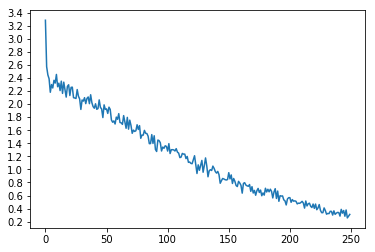

In [30]:
hidden_size = 128
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = AttnDotDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
#decoder1 = AttnMultiplicativeDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
#decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

#encoder1.load_state_dict(torch.load('encoder_params'))
#decoder1.load_state_dict(torch.load('decoder_params'))
trainIters(encoder1, decoder1, 25000, print_every=1000, learning_rate = 0.01, attention = True)
torch.save(encoder1.state_dict(), 'encoder_params')
torch.save(decoder1.state_dict(), 'decoder_params')

In [34]:
print("Evaluating 10 random examples from training")
evaluateRandomly(encoder1, decoder1, attention=True)

Evaluating 10 random examples from training
> nous descendons .
= we re going down .
debug: in evaluate
< we re going down . <EOS>

> nous sommes normaux .
= we re normal .
debug: in evaluate
< we re normal . <EOS>

> nous perdons toutes du temps .
= we re all wasting time .
debug: in evaluate
< we re all wasting time . <EOS>

> nous ne sommes pas du coin .
= we re not from around here .
debug: in evaluate
< we re not from around here . <EOS>

> nous allons gravir cette montagne .
= we are going to climb that mountain .
debug: in evaluate
< we are going to climb that mountain . <EOS>

> nous sommes malchanceuses .
= we re unlucky .
debug: in evaluate
< we re surprised . <EOS>

> on ne sort pas ensemble officiellement .
= we re not officially dating .
debug: in evaluate
< we re not living yet . <EOS>

> nous sommes supposes connaitre les regles .
= we are supposed to know the rules .
debug: in evaluate
< we are to to the the rules . <EOS>

> nous sommes dans le petrin .
= we re in troub

In [35]:
print("Evaluating the 10 held out test examples")
evaluateTestSet(encoder1, decoder1, attention=True)

Evaluating the 10 held out test examples
debug: in evaluateTestSet
> nous sommes toutes ensemble a l instant .
= we re all together right now .
debug: in evaluate
< we re all together right now . <EOS>

> nous sommes hors de danger .
= we are out of danger .
debug: in evaluate
< we are free from danger . <EOS>

> nous nous faisons des idees .
= we re imagining things .
debug: in evaluate
< we re having a . <EOS>

> nous cherchons un endroit ou dormir .
= we re looking for a place to sleep .
debug: in evaluate
< we re getting a a lot of fun . <EOS>

> nous nous rechauffons .
= we re getting warmer .
debug: in evaluate
< we re worried . <EOS>

> nous sommes certaines .
= we re certain .
debug: in evaluate
< we re strong . <EOS>

> nous sommes tous la .
= we re all here .
debug: in evaluate
< we re all here . <EOS>

> nous sommes puissantes .
= we re powerful .
debug: in evaluate
< we re sad . <EOS>

> nous sommes tous aneantis .
= we re all devastated .
debug: in evaluate
< we re all arm

Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




debug: in evaluate


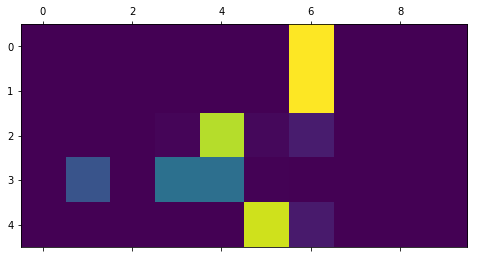

In [36]:
output_words, attentions = evaluate(
    encoder1, decoder1, "nous sommes des nouvelles venues .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




debug: in evaluate
input = nous descendons .
output = we re going down . <EOS>


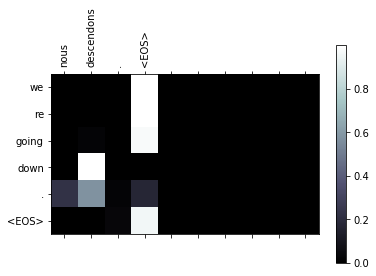

debug: in evaluate
input = nous sommes normaux .
output = we re normal . <EOS>


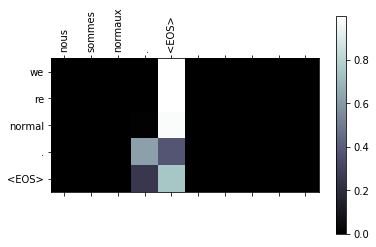

debug: in evaluate
input = nous perdons toutes du temps .
output = we re all wasting time . <EOS>


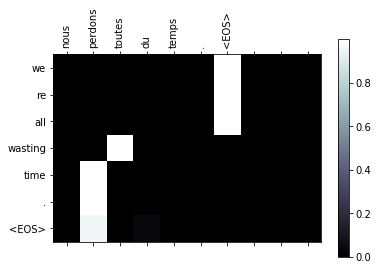

debug: in evaluate
input = nous ne sommes pas du coin .
output = we re not from around here . <EOS>


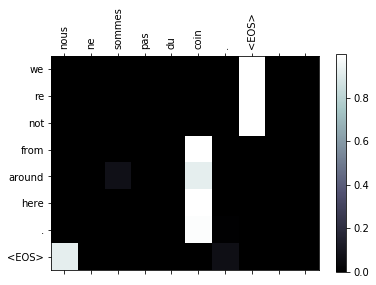

debug: in evaluate
input = nous allons gravir cette montagne .
output = we are going to climb that mountain . <EOS>


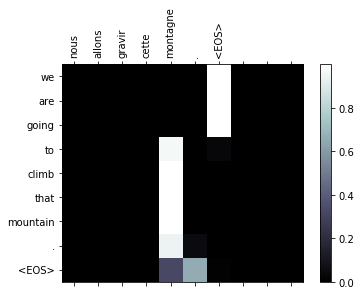

debug: in evaluate
input = nous sommes malchanceuses .
output = we re surprised . <EOS>


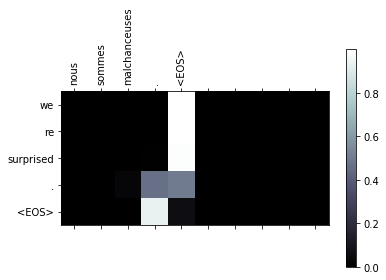

debug: in evaluate
input = on ne sort pas ensemble officiellement .
output = we re not living yet . <EOS>


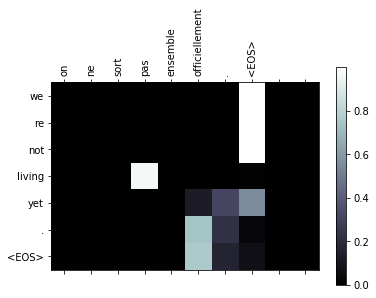

debug: in evaluate
input = nous sommes supposes connaitre les regles .
output = we are to to the the rules . <EOS>


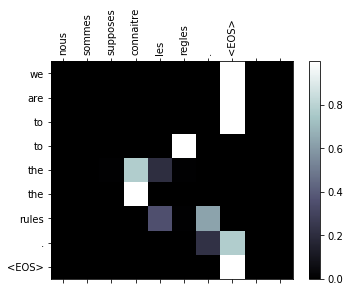

debug: in evaluate
input = nous sommes dans le petrin .
output = we re in trouble . <EOS>


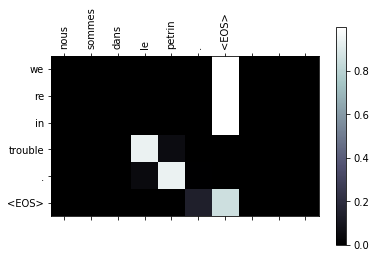

debug: in evaluate
input = nous sommes devouees .
output = we re dedicated . <EOS>


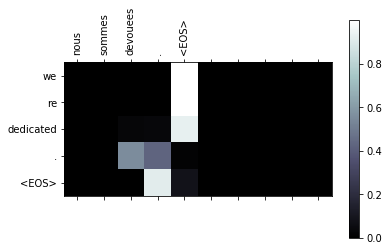

In [37]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

#for pair in testPairs:
for i in range(10):
    pair = trainPairs[i]
    evaluateAndShowAttention(pair[0])

#evaluateAndShowAttention("ils envoient de l aide .")
#evaluateAndShowAttention("nous allons peindre le mur .")

#evaluateAndShowAttention("nous nous rejouissons de vous revoir .")

#evaluateAndShowAttention("ils sont sortis faire les magasins .")

#evaluateAndShowAttention("nous sommes sous son commandement .")

Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there




# Credits
The original notebook was written by Sean Robertson <https://github.com/spro/practical-pytorch>_

# Recommended Reading:

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <https://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <https://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <https://arxiv.org/abs/1506.05869>`__

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

And for more, read the papers that introduced these topics:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <https://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <https://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <https://arxiv.org/abs/1506.05869>`__